## Wstęp do uczenia maszynowego
### Praca domowa 7
#### Paweł Fijałkowski

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score

In [8]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

In [9]:
test.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750
1,0,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278
2,0,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520
3,0,12.47,1.52,2.20,19.0,162,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937
4,0,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625


In [4]:
val.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.86,1.51,2.67,25.0,86,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410
1,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
2,12.82,3.37,2.30,19.5,88,1.48,0.66,0.40,0.97,10.26,0.72,1.75,685
3,12.37,1.07,2.10,18.5,88,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660
4,13.50,1.81,2.61,20.0,96,2.53,2.61,0.28,1.66,3.52,1.12,3.82,845


Widzimy więc, że zgodnie z poleceniem, zbiór testowy zawiera informację o przynależności obserwacji do klasy outlierów.

array([[<AxesSubplot:title={'center':'class'}>,
        <AxesSubplot:title={'center':'Alcohol'}>,
        <AxesSubplot:title={'center':'Malic acid'}>,
        <AxesSubplot:title={'center':'Ash'}>],
       [<AxesSubplot:title={'center':'Alcalinity of ash'}>,
        <AxesSubplot:title={'center':'Magnesium'}>,
        <AxesSubplot:title={'center':'Total phenols'}>,
        <AxesSubplot:title={'center':'Flavanoids'}>],
       [<AxesSubplot:title={'center':'Nonflavanoid phenols'}>,
        <AxesSubplot:title={'center':'Proanthocyanins'}>,
        <AxesSubplot:title={'center':'Color intensity'}>,
        <AxesSubplot:title={'center':'Hue'}>],
       [<AxesSubplot:title={'center':'OD280/OD315 of diluted wines'}>,
        <AxesSubplot:title={'center':'Proline'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

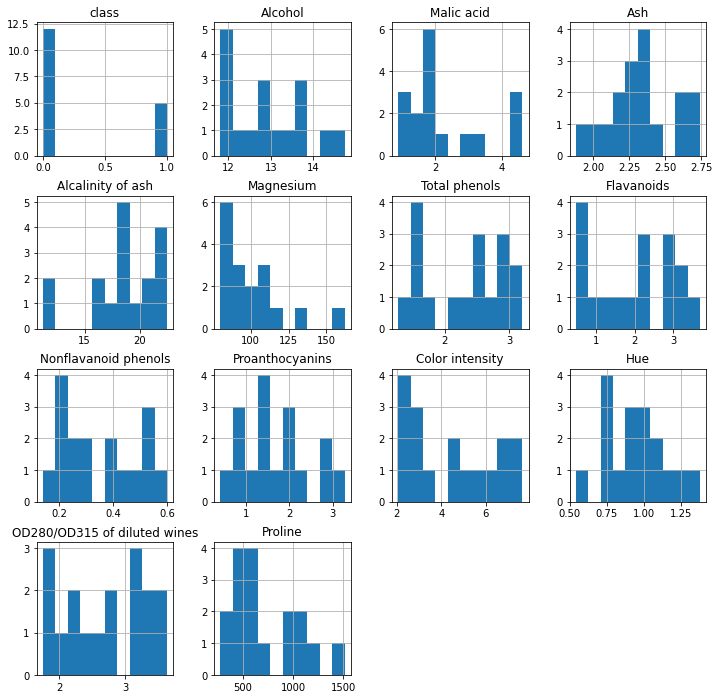

In [13]:
test.hist(figsize=(12,12))

In [16]:
test.isnull().sum().sum()

0

In [18]:
val.isnull().sum().sum()

0

In [20]:
train.isnull().sum().sum()

0

Po wstępnym zapoznaniu się z rozkładami zmiennych w zbiorze danych oraz stwierdzeniu absencji braków danych, możemy przejść do modelowania.

Wykorzystamy algorytm GMM (`Gaussian Mixture Models`) do wykrywania wartości odstających w naszym zbiorze danych. Algorytm ten przyporządkowywuje prawdopodobieństwo przynależenia obserwacji do danego klastra. Ustawiając minimalne prawdopodobieństwo przynależenia do któregoś z klastrów, możemy oddzielić obserwacje spełniające ten warunek od tych nie spełniających (dokonać klasyfikacji).

Poniżej postaramy się znaleźć najbardziej optymalną ilość klastrów. Wykorzystamy do tego metodę `bic`.

In [34]:
my_bic = []

where = range(1, 8)

for i in where:
    current_try_gmm = GaussianMixture(n_components = i, random_state = 37)
    current_try_gmm.fit(train)
    my_bic.append(current_try_gmm.bic(train))

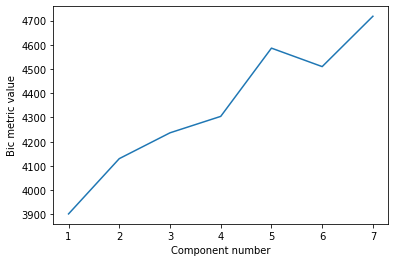

In [35]:
plt.plot(where, my_bic)
plt.xlabel("Component number")
plt.ylabel("Bic metric value")
plt.show()

Chcąc minimalizować wartość metryki `BIC` przyjmiemy jako optymalną ilość komponentów - 1.

In [37]:
gmm = GaussianMixture(n_components=1, random_state=37)
gmm.fit(train)

GaussianMixture(random_state=37)

Porównamy teraz rozkłady prawdopodobieństw przynależenia do klastra pomiędzy obserwacjami w zbiorze treningowym i walidacyjnym. Wiem, że w treningowym nie występują outliery, więc jako threshold możemy wybrać minimalną wartość z przynależenia obliczaną dla obserwacji w tym zbiorze.

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

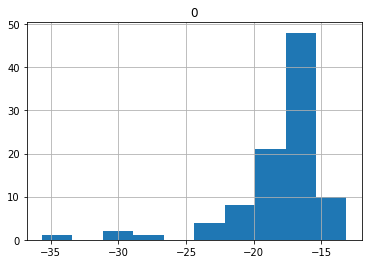

In [41]:
inliers_probability = gmm.score_samples(train)
pd.DataFrame(inliers_probability).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

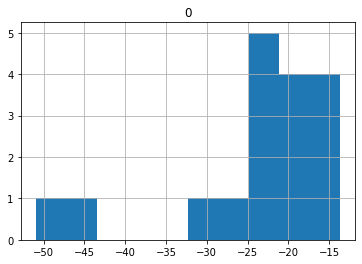

In [42]:
all_probability = gmm.score_samples(val)
pd.DataFrame(all_probability).hist()

Widzimy więc, że inliery spełniają warunek `prawdopodobieństwo_przynależenia > -30`. Wykorzystamy go do podziału na grupy obserwacji odstających/nieodstających.

Wyznaczymy teraz na zbiorze testowym serię metryk, celem kwantyfikacji osiągniętego rezultatu. 

In [54]:
test_probability = gmm.score_samples(test.drop(columns=["class"]))
classified = (test_probability < -30).astype(int)
y_real = test["class"]

In [60]:
results = pd.DataFrame(
    [{"Metric":"precision", "Value": precision_score(y_real, classified)},
     {"Metric":"recall", "Value": recall_score(y_real, classified)},
     {"Metric":"score", "Value": f1_score(y_real, classified)}],
    columns=["Metric", "Value"]
)
results

,Metric,Value
0,precision,0.833333
1,recall,1.000000
2,score,0.909091


Mały rozmiar zbioru danych nie pozwala nam na szersze wnioski, ale przy zadanych warunkach udało się przy pomocy GMM, stworzyć całkiem sensowny klasyfikator wartości odstających (wyznaczone metryki precyzji czy czułości mają akcpetowalne wartości).

Bez wątpienia jest to jedna z ciekawszych metod detekcji wartości odstających, można jednak poszukać usprawnień jej pracy poprzez np. zmianę sposobu doboru warunku krańcowego prawdopodobieństwa (poniżej którego traktujemy obserwację jako odstające.